## Tests of SimplePESamples class

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy

from pycbc import conversions, psd
from pycbc.filter import match

from simple_pe.param_est import metric, pe
from simple_pe.param_est.pe import SimplePESamples

from pesummary.gw.conversions import convert

In [2]:
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

In [3]:
npts = int(1e6)

In [4]:
ifos = ['H1', 'L1', 'V1']

psds = {'H1': 'aLIGOMidHighSensitivityP1200087',
        'L1': 'aLIGOMidHighSensitivityP1200087',
        'V1': 'AdVMidHighSensitivityP1200087',
        'f_low': 20.,
        'f_high': 8192,
        'length': 32
        }

psds['delta_f'] = 1. / psds['length']

approximant = 'IMRPhenomXPHM'

In [5]:
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])

pycbc_psd['harm'] = 3. / sum([1. / pycbc_psd[ifo] for ifo in ifos])

/home/spxsf2/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return self._data.__rtruediv__(other)


In [6]:
m1 = 30.
m2 = 10.
mc = conversions.mchirp_from_mass1_mass2(m1, m2)
eta = conversions.eta_from_mass1_mass2(m1, m2)
s1z = 0.3
s2z = 0.
chi_eff = conversions.chi_eff(m1, m2, s1z, s2z)
snr = 18

a_net = 0.2

In [7]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'chi_eff':chi_eff
        }

In [8]:
dxs = {'chirp_mass': 0.1,
      'symmetric_mass_ratio': 0.03,
      'chi_eff': 0.1}

Generate an initial samples dict in mass and spin space

In [9]:
pts = {}
for x in params:
    pts[x] = np.random.uniform(params[x] - dxs[x], params[x] + dxs[x], npts)

In [10]:
pts

{'chirp_mass': array([14.70630599, 14.67749944, 14.66532739, ..., 14.69605079,
        14.63428312, 14.64512727]),
 'symmetric_mass_ratio': array([0.1821849 , 0.21452987, 0.18154549, ..., 0.20639816, 0.18819473,
        0.15863538]),
 'chi_eff': array([0.20462919, 0.20368419, 0.27419609, ..., 0.13105059, 0.20203813,
        0.24732493])}

In [11]:
samples = SimplePESamples(pts)

Initial distributions

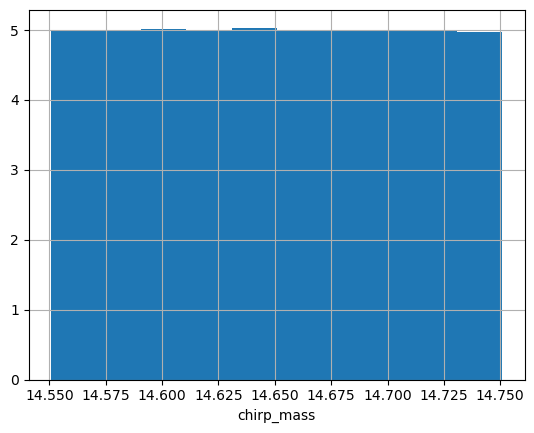

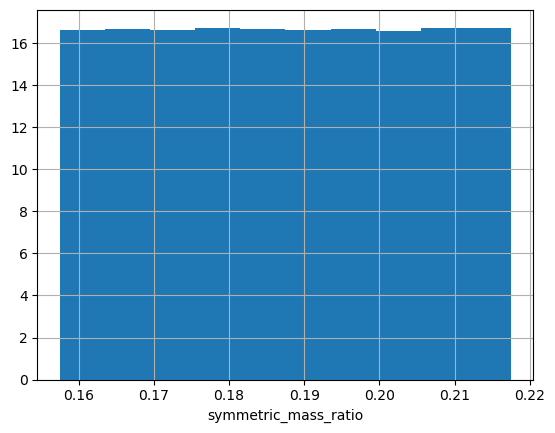

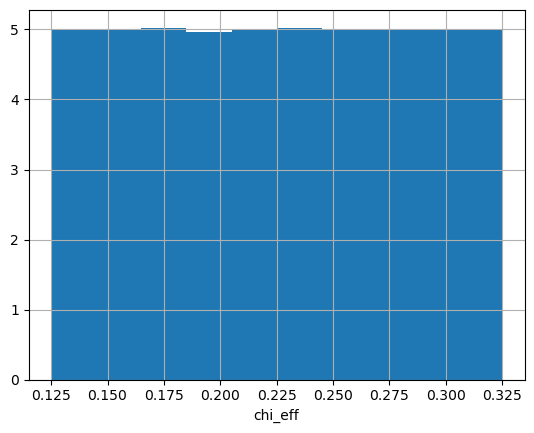

In [12]:
for x in samples.keys():
    plt.figure()
    plt.hist(samples[x], density=True)
    plt.xlabel(x)
    plt.grid()

Generate theta_jn

In [13]:
samples.generate_theta_jn(theta_dist='uniform')

In [14]:
thetas = ['uniform', 'left_circ', 'right_circ']

Overwriting theta_jn values
Overwriting cos_theta_jn values
Overwriting theta_jn values
Overwriting cos_theta_jn values
Overwriting theta_jn values
Overwriting cos_theta_jn values


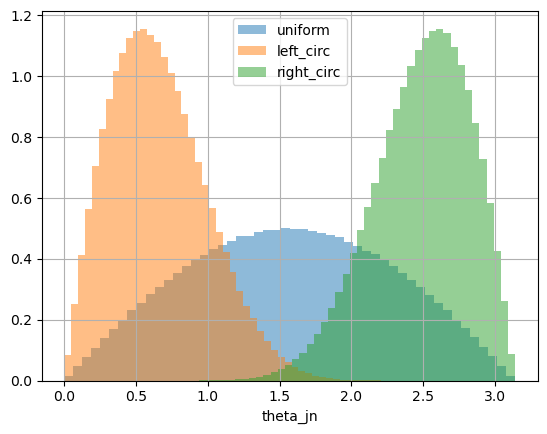

In [15]:
for theta in thetas:
    samples.generate_theta_jn(theta_dist = theta, overwrite=True)
    plt.hist(samples['theta_jn'], density=True, label=theta, alpha=0.5, bins=50)
    
plt.xlabel('theta_jn')
plt.grid()
plt.legend()    

Overwriting theta_jn values
Overwriting cos_theta_jn values
Overwriting theta_jn values
Overwriting cos_theta_jn values
Overwriting theta_jn values
Overwriting cos_theta_jn values


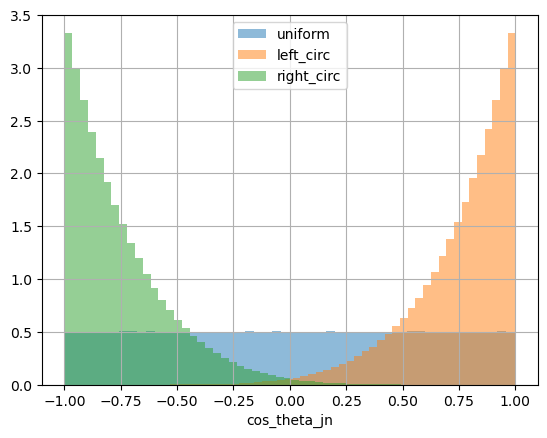

In [16]:
for theta in thetas:
    samples.generate_theta_jn(theta_dist = theta, overwrite=True)
    plt.hist(samples['cos_theta_jn'], density=True, label=theta, alpha=0.5, bins=50)
    
plt.xlabel('cos_theta_jn')
plt.grid()
plt.legend()   

#### Verify theta_jn distributions

Generate uniform in cosi and volume and keep points which have a specific snr in left/right polarization

In [17]:
d = np.random.power(3, npts)
cosi = np.random.uniform(-1, 1, npts)
rho_l = (1 + cosi)**4/(4 * d)**2

Text(0.5, 0, 'distance')

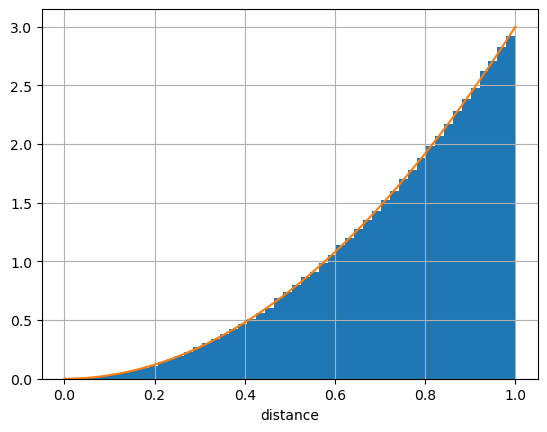

In [18]:
plt.hist(d, bins=50, density=True)
x = np.linspace(0,1,100)
plt.plot(x, 3 * x**2)
plt.grid()
plt.xlabel('distance')

Text(0.5, 0, 'cos theta')

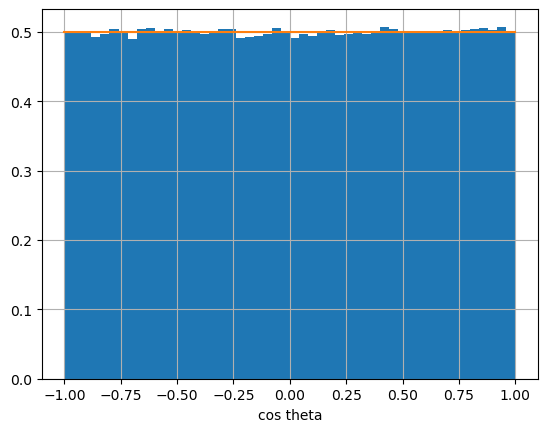

In [19]:
plt.hist(cosi, bins=50, density=True)
ci = np.linspace(-1, 1, 100)
plt.plot(ci, 0.5 * np.ones_like(ci))
plt.grid()
plt.xlabel('cos theta')

In [20]:
k = (rho_l < 1.1) & (rho_l > 1.0)

Text(0.5, 0, 'distance')

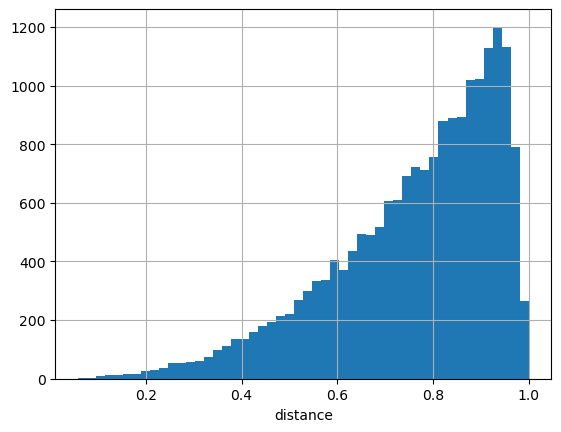

In [21]:
plt.hist(d[k], bins=50)
plt.grid()
plt.xlabel('distance')

Text(0, 0.5, 'cos theta')

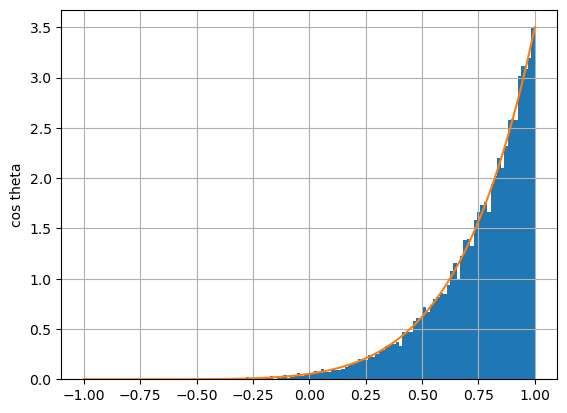

In [22]:
plt.hist(cosi[k], bins=100, density=True)
plt.plot(ci, ((1 + ci)/2)**6 * 7/2)
plt.grid()
plt.ylabel('cos theta')

Overwriting theta_jn values
Overwriting cos_theta_jn values


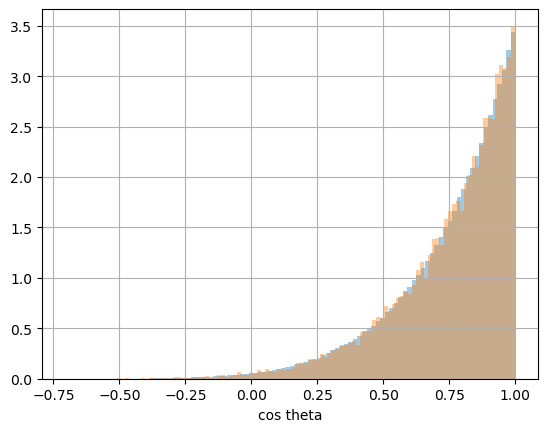

In [23]:
samples.generate_theta_jn(theta_dist = 'left_circ', overwrite=True)

plt.hist(samples['cos_theta_jn'], bins=100, density=True, alpha=0.4)
plt.hist(cosi[k], bins=100, density=True, alpha=0.4)
plt.xlabel('cos theta')

plt.grid()

In [24]:
samples.generate_all_posterior_samples()

In [25]:
max(samples['viewing_angle'] - samples['theta_jn'])

0.0

## Generate hm and prec SNRS

Generate chi_p and theta_jn points

In [26]:
samples.generate_chi_p('uniform')
samples.generate_theta_jn(theta_dist = 'left_circ')

Did not overwrite theta_jn and cos_theta_jn samples


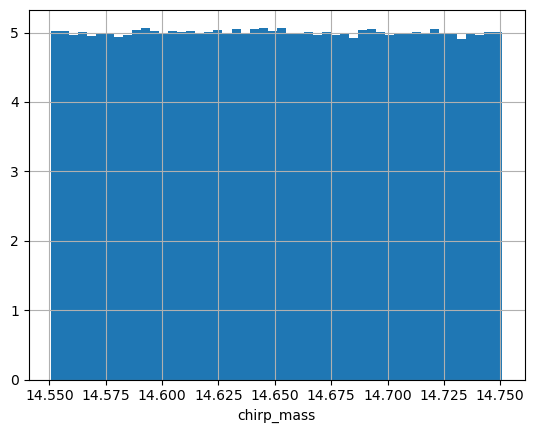

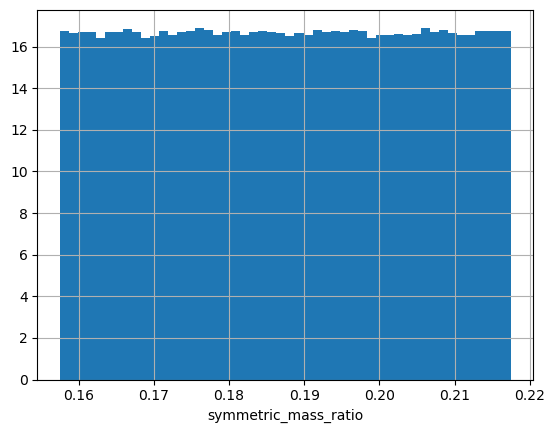

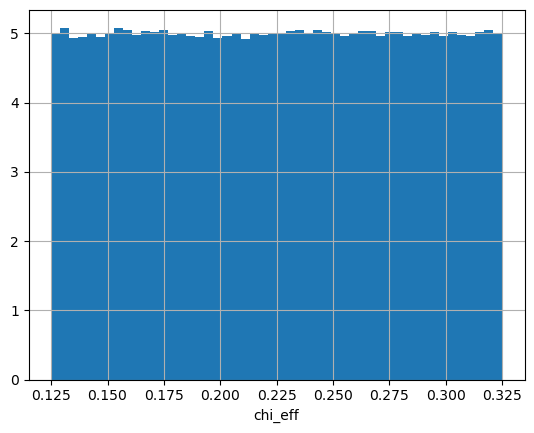

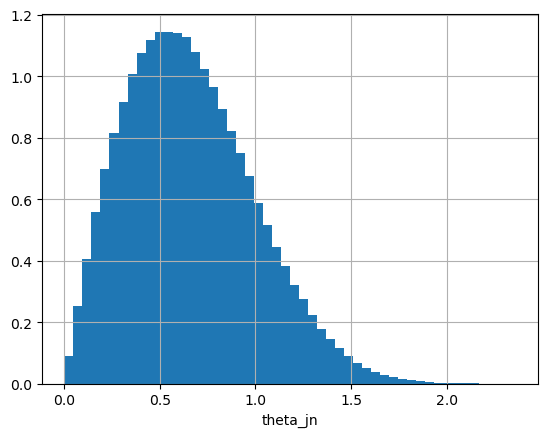

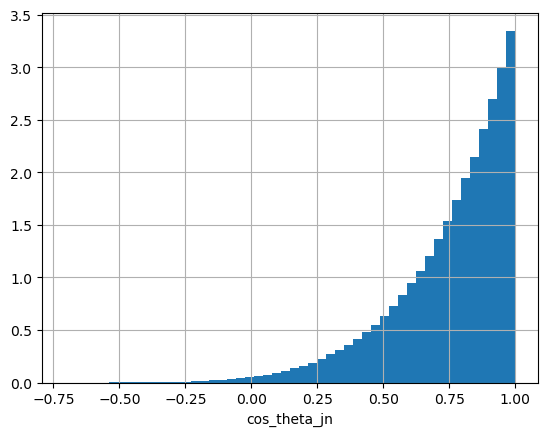

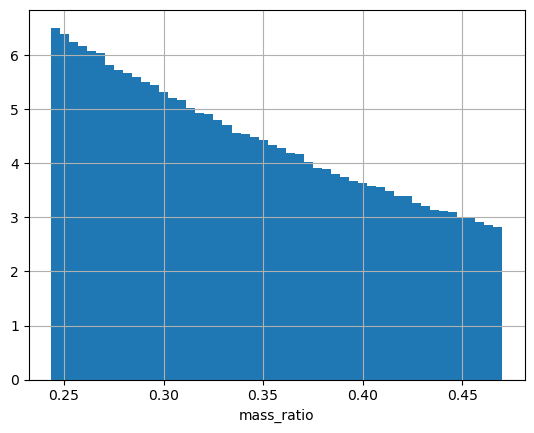

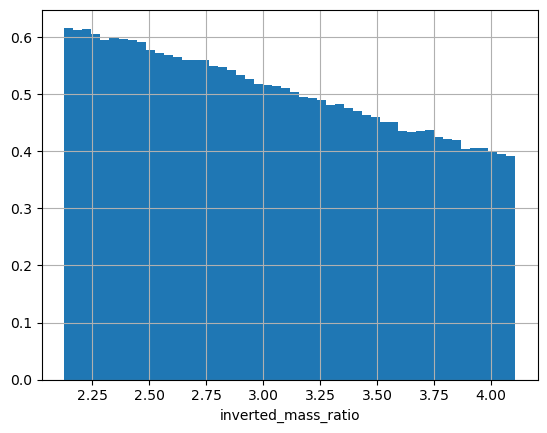

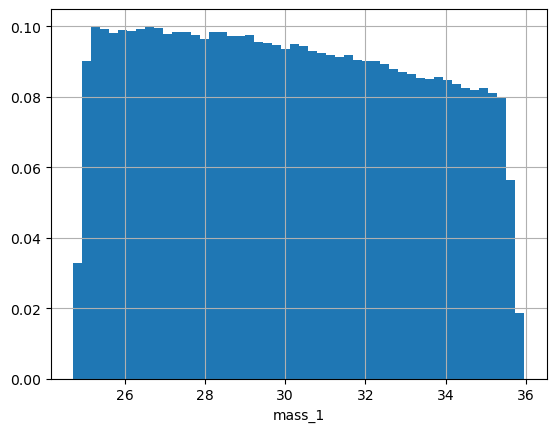

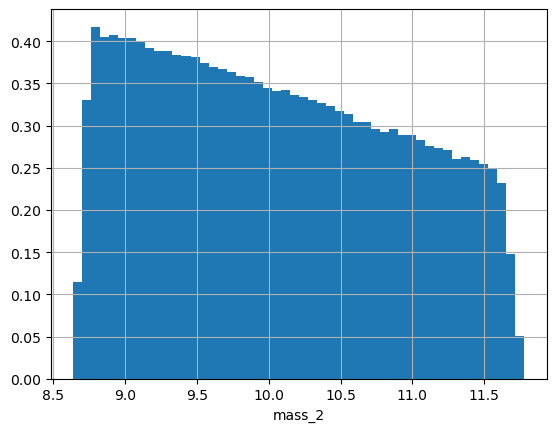

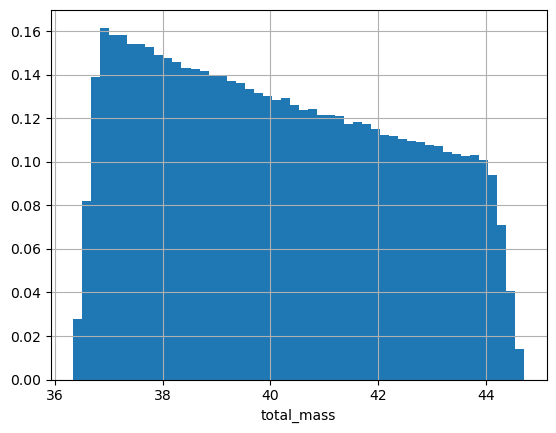

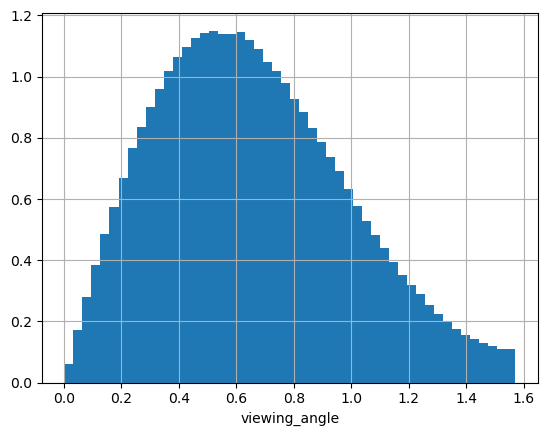

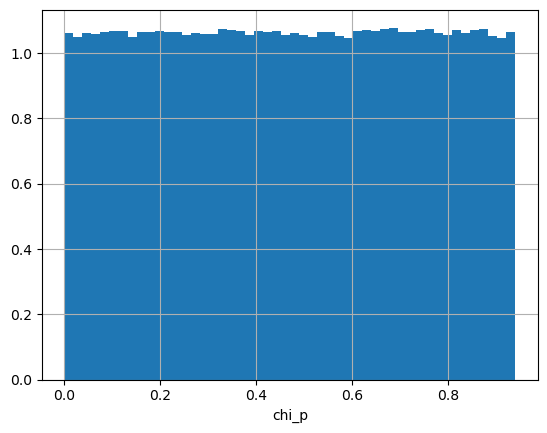

In [27]:
for x in samples.keys():
    plt.figure()
    plt.hist(samples[x], density=True, bins=50)
    plt.xlabel(x)
    plt.grid()

In [28]:
modes = ['33'] #, '44']
hm_interp_dirs = ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
prec_interp_dirs = ['symmetric_mass_ratio', 'chi_eff', 'chi_p']
interp_points = 7
approximant="IMRPhenomXPHM"

In [29]:
samples.calculate_rho_lm(pycbc_psd['harm'], psds['f_low'], snr, modes,
                                 hm_interp_dirs, interp_points, approximant)

samples.calculate_rho_2nd_pol(a_net, snr)

samples.calculate_rho_p(pycbc_psd['harm'], psds['f_low'], snr,
                                 prec_interp_dirs, interp_points, approximant)

calculating alpha_lm on grid: 100%|███████████| 343/343 [03:33<00:00,  1.61it/s]


## SNR dependence on parameters

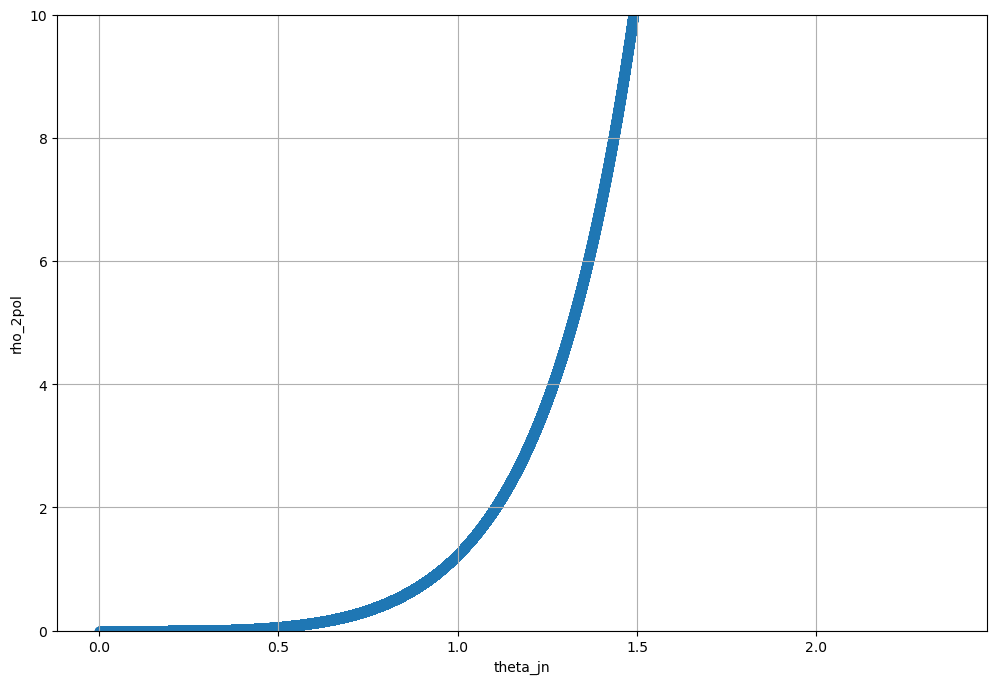

In [30]:
var = ['theta_jn', 'rho_2pol']
plt.figure(figsize=(12,8))
plt.scatter(samples[var[0]], samples[var[1]])
plt.xlabel(var[0])
plt.ylabel(var[1])
plt.ylim([0,10])
plt.grid()

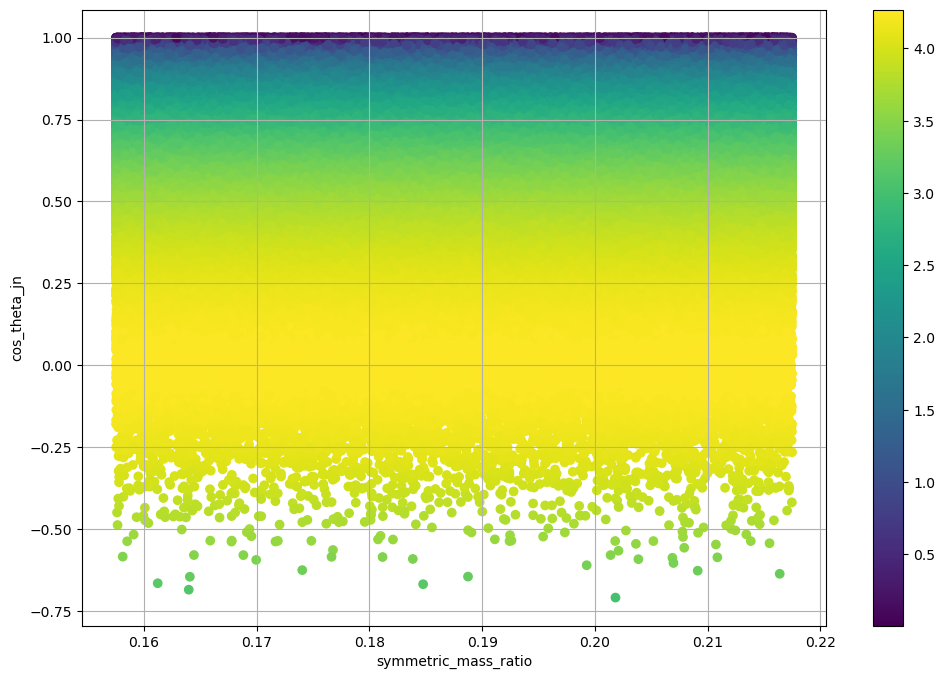

In [31]:
var = ['symmetric_mass_ratio', 'cos_theta_jn']
color = 'rho_33'
plt.figure(figsize=(12,8))
plt.scatter(samples[var[0]], samples[var[1]], c=samples[color])
plt.xlabel(var[0])
plt.ylabel(var[1])
plt.colorbar()
plt.grid()

In [ ]:
var = ['chi_p', 'cos_theta_jn']
color = 'rho_p'
plt.figure(figsize=(12,8))
plt.scatter(samples[var[0]], samples[var[1]], c=samples[color])
plt.xlabel(var[0])
plt.ylabel(var[1])
plt.colorbar()

### Reweight points based on observed SNRs

In [ ]:
rho = {}
rho['33'] = 4.0
rho['p'] = 3.0
rho['2pol']= 2.0

In [ ]:
samples.calculate_hm_prec_probs({'33':rho['33']}, rho['p'], rho['2pol'])

In [ ]:
var = '2pol'
plt.figure(figsize=(12,8))
plt.scatter(samples['rho_' + var], samples['p_' + var])
plt.xlim(0, 2* rho[var])
plt.axvline(rho[var], c='r', linewidth=3)
plt.xlabel('rho_' + var)
plt.ylabel('p_' + var)

In [ ]:
var = 'theta_jn'
snr = '2pol'
plt.figure(figsize=(12,8))
fig, ax = plt.subplots(2)
ax[0].scatter(samples[var], samples['rho_' + snr])
ax[0].set_ylim(0, 2* rho[snr])
ax[0].axhline(rho[snr], c='r', linewidth=3)
ax[0].set_ylabel('rho_' + snr)

ax[1].scatter(samples[var], samples['p_' + snr])
ax[1].set_ylabel('p_' + var)

plt.xlabel(var[0])

In [ ]:
var = '33'
plt.figure(figsize=(12,8))
plt.scatter(samples['rho_' + var], samples['p_' + var])
plt.xlim(0, 2* rho[var])
plt.axvline(rho[var], c='r', linewidth=3)
plt.xlabel('rho_' + var)
plt.ylabel('p_' + var)

In [ ]:
var = ['symmetric_mass_ratio', 'theta_jn']
color = 'p_33'
plt.figure(figsize=(12,8))
plt.scatter(samples[var[0]], samples[var[1]], c=samples[color])
plt.xlabel(var[0])
plt.ylabel(var[1])
plt.colorbar(label=color)

In [ ]:
var = 'p'
plt.figure(figsize=(12,8))
plt.scatter(samples['rho_' + var], samples['p_' + var])
plt.xlim(0, 2* rho[var])
plt.axvline(rho[var], c='r', linewidth=3)
plt.xlabel('rho_' + var)
plt.ylabel('p_' + var)

In [ ]:
var = ['chi_p', 'theta_jn']
color = 'p_p'
plt.figure(figsize=(12,8))
plt.scatter(samples[var[0]], samples[var[1]], c=samples[color])
plt.xlabel(var[0])
plt.ylabel(var[1])
plt.colorbar(label=color)

In [ ]:
var = ['chi_p', 'theta_jn']
color = 'weight'
plt.figure(figsize=(12,8))
plt.scatter(samples[var[0]], samples[var[1]], c=samples[color])
plt.xlabel(var[0])
plt.ylabel(var[1])
plt.colorbar(label=color)